# Burst and glitches sampler

# Plan
1. generate dataset
    1. create burst waveform (start with Sine-Gaussian toy model)
    2. plug it in `LISAInstrument` and simulate it

    OR
    
    3. do it with `fastlisaresponse`

2. plug it in `lisaanalysistools` `AnalysisContainer`
3. set up Eryn sampler

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In [2]:
import matplotlib as mpl
# Set up plot style for all plots in the notebook
mpl.rcParams.update({'axes.grid' : True,
                     'figure.figsize': [10, 5]})
# mpl.rcParams.items

## Sine gaussian waveform with `fastlisaresponse`
### Define Sine gaussian burst with sky localization parameters

In [3]:
def SineGaussianBurst(glitch_param_list, t, **kwargs):
    """
    A Sine-Gaussian function with 5 parameters.
    
    Inputs:
     - A:     sine amplitude
     - f0:    sine central frequency
     - phi0:  sine intial phase
     - sigma: gaussian width
     - t0:    gaussian central time
     - t:     time

    Return:
     - Sine-Gaussian
    """
    A, f0, phi0, sigma, t0 = glitch_param_list
    
    S = A*np.cos(phi0 + 2*np.pi*f0*(t - t0))
    G = np.exp(- (t - t0)**2 / (2*sigma**2))
    
    return np.complex128(S*G)


def periodic_SineGaussianBurst(glitch_param_list, t, period, **kwargs):
    """
    Sum multiple Sine-Gaussian functions with 5 parameters.
    Calls the `SineGaussian` function.
    
    Inputs:
     - glitch_param_list: list of glitch parameter lists
     - t:                 time

    Return:
     - Summed Sine-Gaussian
    """
    template = SineGaussianBurst(*glitch_param_list, t)

    reps = t[-1]/period
    print(reps, np.round(reps, 0))
    
    for k in range(1,np.int64(reps)):
        
        # First make sure there are no NaNs in the array!
        template += SineGaussianBurst(*glitch_param_list, t-k*period) + SineGaussianBurst(*glitch_param_list, t+k*period)
    return template

7.999768518518518 8.0


/Users/ecastel2/Documents/virtual-envs/miniconda/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ecastel2/Documents/virtual-envs/miniconda/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


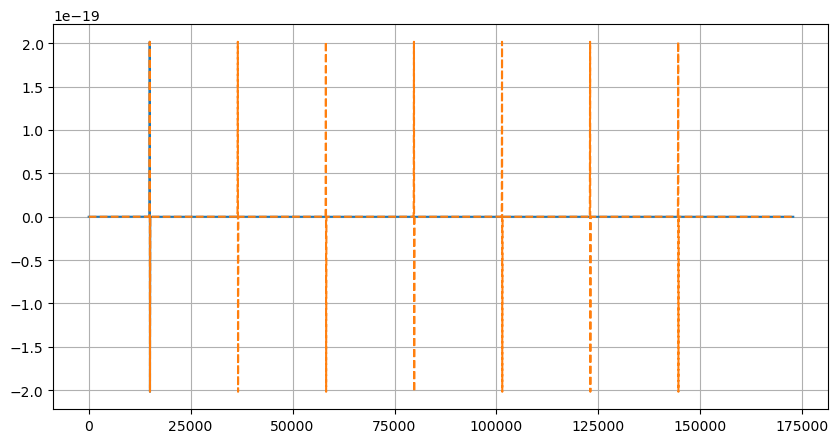

In [12]:
dt = 5
Tobs = 60 * 60 * 24 * 2

# sgparams = dict(
A = 1e-18 # to get a peak height of 1e-21
f0 = 1.8e-3
phi0 = np.pi/2
sigma = 30
t0 = 15000

lamb = np.pi/2
beta = 0

period = 60 * 60 * 6
# )

times = np.arange(0, Tobs, dt)

burst = SineGaussianBurst([A, f0, phi0, sigma, t0], times)
burst_periodic = periodic_SineGaussianBurst([A, f0, phi0, sigma, t0], times, period)


plt.plot(times, burst)
plt.plot(times, burst_periodic, ls='--')
# plt.xlim([9000,11000])

### Define LISA Response wrapper


In [13]:
# imports
from fastlisaresponse import ResponseWrapper
from lisatools.detector import EqualArmlengthOrbits

In [14]:
# if burst_response:
#     del burst_response 
# Tobs = 0.001 # observation time in years
tstart = 5000.0 # start time

# order of the langrangian interpolation
order = 25

# 1st or 2nd or custom (see docs for custom)
tdi_gen = "2nd generation"

tdi_kwargs = dict(
    order=order, tdi=tdi_gen, tdi_chan="XYZ",
)

burst_response = ResponseWrapper(
    waveform_gen = SineGaussianBurst, # it takes a generic waveform generator - can be whatever type of waveform you want
    waveform_gen = periodic_SineGaussianBurst, # it takes a generic waveform generator - can be whatever type of waveform you want
    Tobs = Tobs/YRSID_SI,
    dt = dt,
    index_lambda = 2, index_beta = 3,
    # index_lambda = 3, index_beta = 4,
    t0 = tstart,
    flip_hx = False,  # set to True if waveform is h+ - ihx
    use_gpu = False,
    remove_sky_coords = True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude = False,
    remove_garbage= False,  # removes the beginning of the signal that has bad information
    orbits = EqualArmlengthOrbits(),
    **tdi_kwargs
)

In [15]:
# times = np.arange(0, Tobs * YRSID_SI, dt)
# call response function and generate the TDI response
tdis = burst_response([A, f0, phi0, sigma, t0], times, lamb, beta)
# tdis = burst_response([A, f0, phi0, sigma, t0], times, period, lamb, beta)

7.999768518518518 8.0


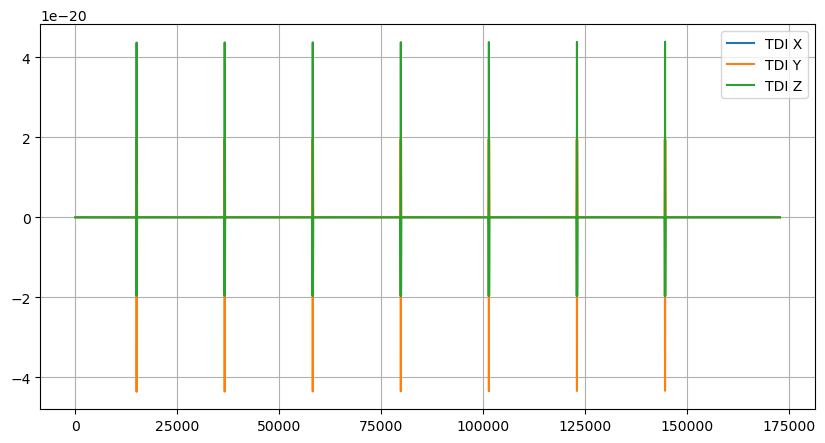

In [16]:
# plt.plot(times[int(tstart/dt)+1:-int(tstart/dt)], tdis[1])

plt.plot(times, tdis[0], label = 'TDI X')
plt.plot(times, tdis[1], label = 'TDI Y')
plt.plot(times, tdis[2], label = 'TDI Z')

# plt.ylim([-1e-22,1e-22])
# plt.xlim([t0-200,t0+200])
plt.legend()


## SineGaussian waveform with GWresponse

In [ ]:
from lisagwresponse import ReadStrain
from lisaorbits import EqualArmlengthOrbits

In [ ]:
from pytdi.michelson import X1, X2, Y2, Z2
from pytdi import Data


In [ ]:
dt = 5

The number of simulated samples is 6311 with a sampling time of 5 seconds.


In [ ]:
!rm LISAorbits.h5

o = EqualArmlengthOrbits()
# size = 100, 
                    # t0 = 0.0, 
                    # dt = dt # commenting this out because of a small bug in LISAOrbits
                #    )
orbit_file = 'LISAorbits.h5'
o.write(orbit_file)
# opt 55.0s

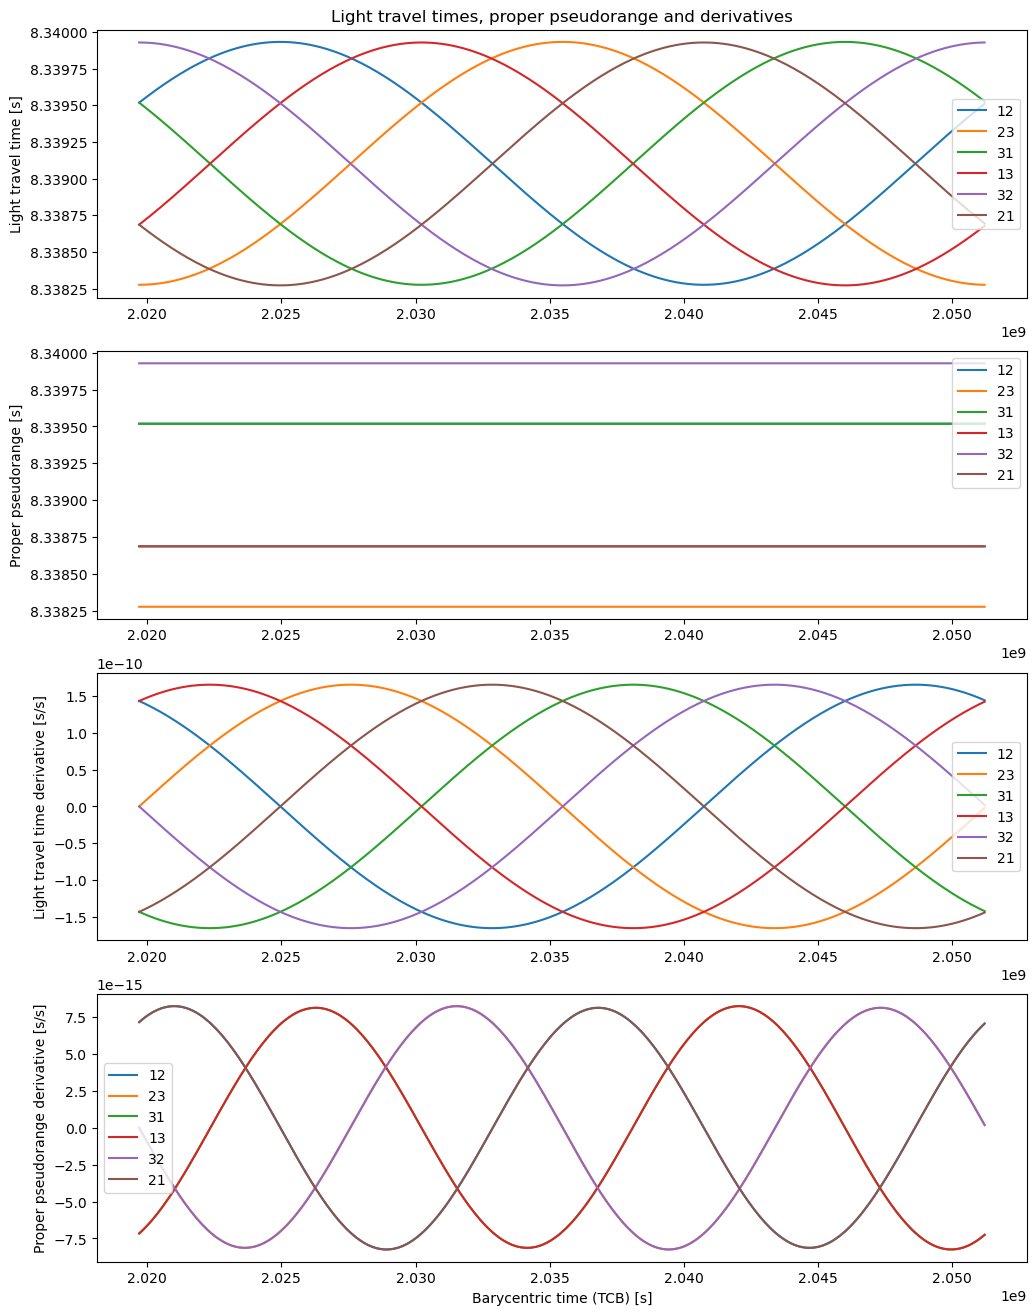

In [ ]:
o.plot_links()

/Users/ecastel2/Documents/virtual-envs/miniconda/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ecastel2/Documents/virtual-envs/miniconda/envs/lisa_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


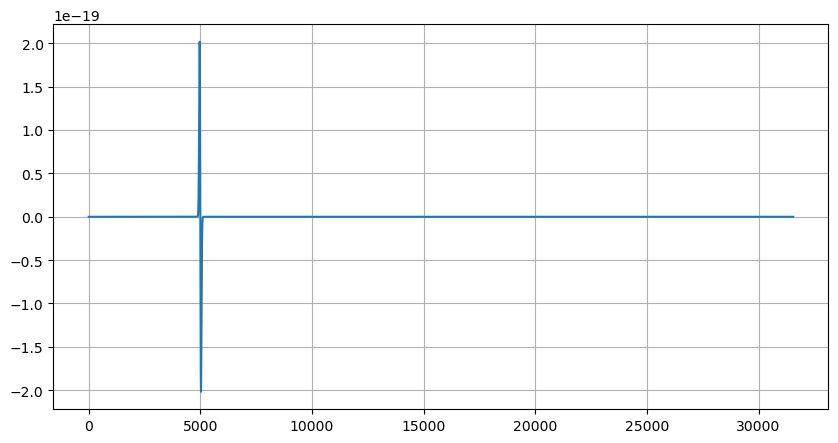

In [ ]:
times = np.arange(0, Tobs*YRSID_SI, dt)

data = SineGaussianBurst(A, f0, phi0, sigma, t0, times)

plt.plot(times, data)

hplus = data
hcross = np.zeros_like(data)

In [ ]:
# Following the LDC conventions1, specify the source localization using the ecliptic latitude and the ecliptic longitude .

burst = ReadStrain(times, hplus, hcross, orbits='LISAorbits.h5', 
                   gw_beta=beta, gw_lambda=lamb, dt=dt, size=times.shape[0])
# burst.plot(burst.t)

You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
/Users/ecastel2/Documents/virtual-envs/miniconda/envs/lisa_env/lib/python3.12/site-packages/scipy/interpolate/_fitpack2.py:740: ComplexWarning: Casting complex values to real discards the imaginary part
  self._data = dfitpack.fpcurf0(x, y, k, w=w, xb=bbox[0],


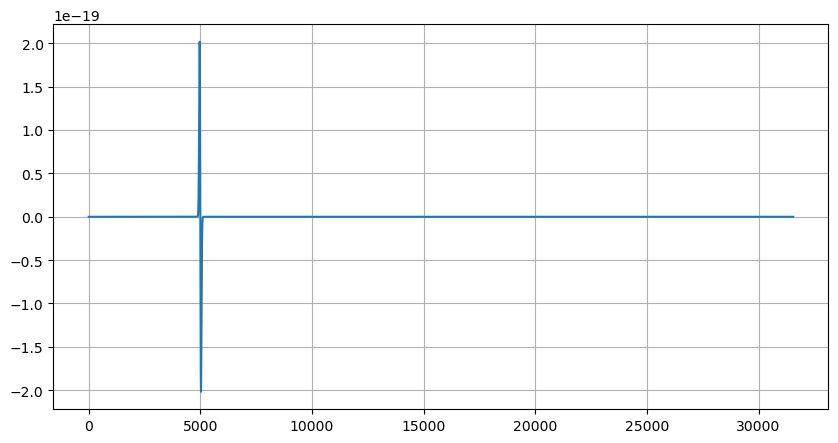

In [ ]:
plt.plot(burst.t,burst.hplus(burst.t))

In [ ]:
burstfile = 'gws.h5'
burst.write(path = burstfile, timeframe='tcb')

You are using a GW file in a version that might not be fully supported
Missing orbit information


ValueError: missing orbit information, use longer orbit file or adjust sampling